# Gesundheitliche Infrastruktur in Dortmund


**Ziel**: Aus mehreren offenen Datensetzen (u.a. Krankenhhäuser, Hospize, Trinkwasserbrunnen, öffentliche Toiletten) werden rumliche Muster, Korrelationen und erste Insights auf Ebene der Stadtbezirke sichtbar gemacht.

**Leitfragen**:
- Wie verteilt sich die Versorgung je Kategorie über die Stadtbezirke?
- Welche Kategorien treten rumlich gemeinsam auf (Korrelationen)?
- Wo gibt es auffüllige über- oder Unterrepräsentationen?

Alle Auswertungen sind explorativ und verwenden nur die vorliegenden Standortdaten. Bevölkerungszahlen oder Bedarfsindikatoren sind **nicht** enthalten und werden als Limitation erwöhnt.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

pd.set_option('display.max_columns', 200)
plt.style.use('seaborn-v0_8')


In [2]:
base = Path('..') / 'data' / 'raw'
files = list(base.glob('*.csv'))
files


[WindowsPath('../data/raw/gesundheitsamt.csv'),
 WindowsPath('../data/raw/hospiz.csv'),
 WindowsPath('../data/raw/krankenhaus.csv'),
 WindowsPath('../data/raw/kurzzeitpflegeeinrichtung.csv'),
 WindowsPath('../data/raw/offentliche-toiletten-behindertengerecht.csv'),
 WindowsPath('../data/raw/offentliche-toiletten.csv'),
 WindowsPath('../data/raw/trinkwasserbrunnen.csv')]

In [3]:
frames = []
for path in files:
    df = pd.read_csv(path, sep=';')
    df['quelle'] = path.stem
    frames.append(df)

raw = pd.concat(frames, ignore_index=True)
raw.head()


,Geografische Koordinate,Objektkategorie,Objektart,Objektname,Objektname-Zusatz,Information-Beschreibung,Information,Straße,Hausnummer,Ort,Link,Telefon,E-Mail,Ostwert,Hochwert,Stadtbezirk Nr,Stadtbezirk,Statistischer Bezirk Nr,Statistischer Bezirk,Unterbezirk Nr,Unterbezirk,Sozialraum Nr,Sozialraum,Aktionsraum Nr,Aktionsraum,Kommune,quelle,Bezeichnung,UUID
0,"51.51258397700987, 7.461511220791514",XE_Behoerde,FachbehoerdeGesundheit,Gesundheitsamt,Sozialpsych. Dienst -Beratungsstelle Mitte,NaN,NaN,Eisenmarkt,3,Dortmund,NaN,NaN,NaN,393241.570000,5.707951e+06,10,Innenstadt-West,0,City,2,City-West,NaN,NaN,NaN,NaN,Dortmund,gesundheitsamt,NaN,NaN
1,"51.53215414243005, 7.4736640757912784",XE_Behoerde,FachbehoerdeGesundheit,Gesundheitsamt,Sozialpsych. Dienst -Beratungsstelle Nord,NaN,NaN,Bornstraße,239,Dortmund,http://www.dortmund.de/de/leben_in_dortmund/ge...,NaN,NaN,394130.230000,5.710109e+06,20,Innenstadt-Nord,50,Nordmarkt,54,Nordmarkt-Ost,NaN,NaN,22.0,Nordmarkt,Dortmund,gesundheitsamt,NaN,NaN
2,"51.512856562526764, 7.458037378938852",XE_Behoerde,FachbehoerdeGesundheit,Gesundheitsamt,Geschäftsstelle,NaN,NaN,Hoher Wall,9-11,Dortmund,https://www.dortmund.de/rathaus/verwaltung/ges...,NaN,NaN,393001.165797,5.707986e+06,10,Innenstadt-West,0,City,2,City-West,NaN,NaN,NaN,NaN,Dortmund,gesundheitsamt,NaN,NaN
3,"51.51088030871351, 7.496839760396437",XE_SozialEinrichtung,Hospiz,Hospiz am Ostpark,NaN,NaN,NaN,Von-der-Tann-Straße,42,Dortmund,http://www.bethel-regional.de/hospiz-am-ostpar...,NaN,hospiz-am-ostpark@bethel.de,395689.060000,5.707710e+06,30,Innenstadt-Ost,70,Kaiserbrunnen,72,Funkenburg,NaN,NaN,NaN,NaN,Dortmund,hospiz,NaN,NaN
4,"51.519968467135115, 7.336018165669756",XE_SozialEinrichtung,Hospiz,Hospiz St. Elisabeth,NaN,NaN,NaN,Bockenfelder Straße,237,Dortmund,http://www.hospiz-westrich.de/,NaN,info@hospiz-westrich.de,384552.590000,5.708962e+06,7,Lütgendortmund,760,Westrich,760,Westrich,NaN,NaN,103.0,Bövinghausen/Westrich,Dortmund,hospiz,NaN,NaN


In [4]:
raw.shape


(232, 29)

## Aufbereitung
Wir extrahieren Latitude/Longitude aus der Spalte `Geografische Koordinate` und definieren einen bereinigten Kategorie-Namen f?r sp?tere Auswertungen.

In [5]:
coords = raw['Geografische Koordinate'].str.split(',', expand=True)
raw['lat'] = pd.to_numeric(coords[0], errors='coerce')
raw['lon'] = pd.to_numeric(coords[1], errors='coerce')

kategorien = {
    'gesundheitsamt': 'Gesundheitsamt',
    'hospiz': 'Hospiz',
    'krankenhaus': 'Krankenhaus',
    'kurzzeitpflegeeinrichtung': 'Kurzzeitpflege',
    'offentliche-toiletten': 'Toiletten',
    'offentliche-toiletten-behindertengerecht': 'Toiletten (barrierefrei)',
    'trinkwasserbrunnen': 'Trinkwasserbrunnen'
}
raw['kategorie'] = raw['quelle'].map(kategorien).fillna(raw['quelle'])

raw[['kategorie', 'Stadtbezirk', 'Statistischer Bezirk', 'Unterbezirk', 'lat', 'lon']].head()


,kategorie,Stadtbezirk,Statistischer Bezirk,Unterbezirk,lat,lon
0,Gesundheitsamt,Innenstadt-West,City,City-West,51.512584,7.461511
1,Gesundheitsamt,Innenstadt-Nord,Nordmarkt,Nordmarkt-Ost,51.532154,7.473664
2,Gesundheitsamt,Innenstadt-West,City,City-West,51.512857,7.458037
3,Hospiz,Innenstadt-Ost,Kaiserbrunnen,Funkenburg,51.510880,7.496840
4,Hospiz,Lütgendortmund,Westrich,Westrich,51.519968,7.336018


## Datenüberblick

In [6]:
raw['kategorie'].value_counts().sort_values(ascending=False)


kategorie
Toiletten                   142
Trinkwasserbrunnen           31
Krankenhaus                  27
Toiletten (barrierefrei)     19
Kurzzeitpflege                6
Hospiz                        4
Gesundheitsamt                3
Name: count, dtype: int64

In [7]:
missing_overview = (
    raw[['Stadtbezirk', 'Statistischer Bezirk', 'Unterbezirk', 'lat', 'lon']]
    .isna()
    .mean()
    .to_frame('fehlend_anteil')
)
missing_overview


,fehlend_anteil
Stadtbezirk,0.0
Statistischer Bezirk,0.0
Unterbezirk,0.0
lat,0.0
lon,0.0


## Verteilung nach Stadtbezirk
Wir betrachten die Anzahl der Standorte je Kategorie und Stadtbezirk.

In [8]:
counts_bezirk = (
    raw.groupby(['Stadtbezirk', 'kategorie'])
    .size()
    .reset_index(name='anzahl')
)
counts_bezirk.head()


,Stadtbezirk,kategorie,anzahl
0,Aplerbeck,Krankenhaus,6
1,Aplerbeck,Kurzzeitpflege,1
2,Aplerbeck,Toiletten,11
3,Aplerbeck,Toiletten (barrierefrei),1
4,Aplerbeck,Trinkwasserbrunnen,1


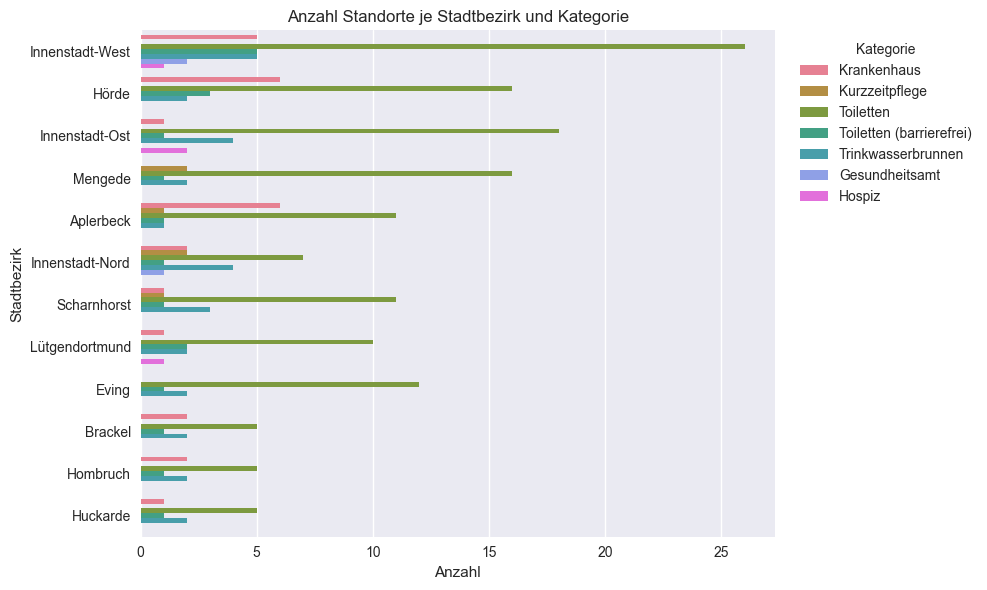

In [9]:
plt.figure(figsize=(10, 6))
order = (
    raw['Stadtbezirk']
    .value_counts()
    .sort_values(ascending=False)
    .index
)

sns.barplot(
    data=counts_bezirk,
    x='anzahl',
    y='Stadtbezirk',
    hue='kategorie',
    order=order
)
plt.title('Anzahl Standorte je Stadtbezirk und Kategorie')
plt.xlabel('Anzahl')
plt.ylabel('Stadtbezirk')
plt.legend(title='Kategorie', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()


## Korrelationen zwischen Kategorien
Wir pivotieren die Anzahl je Stadtbezirk und berechnen die Korrelationen zwischen Kategorien (Pearson).

In [10]:
pivot = counts_bezirk.pivot(index='Stadtbezirk', columns='kategorie', values='anzahl').fillna(0)
pivot


kategorie,Gesundheitsamt,Hospiz,Krankenhaus,Kurzzeitpflege,Toiletten,Toiletten (barrierefrei),Trinkwasserbrunnen
Stadtbezirk,,,,,,,
Aplerbeck,0.0,0.0,6.0,1.0,11.0,1.0,1.0
Brackel,0.0,0.0,2.0,0.0,5.0,1.0,2.0
Eving,0.0,0.0,0.0,0.0,12.0,1.0,2.0
Hombruch,0.0,0.0,2.0,0.0,5.0,1.0,2.0
Huckarde,0.0,0.0,1.0,0.0,5.0,1.0,2.0
Hörde,0.0,0.0,6.0,0.0,16.0,3.0,2.0
Innenstadt-Nord,1.0,0.0,2.0,2.0,7.0,1.0,4.0
Innenstadt-Ost,0.0,2.0,1.0,0.0,18.0,1.0,4.0
Innenstadt-West,2.0,1.0,5.0,0.0,26.0,5.0,5.0


In [11]:
corr = pivot.corr(method='pearson')
corr


kategorie,Gesundheitsamt,Hospiz,Krankenhaus,Kurzzeitpflege,Toiletten,Toiletten (barrierefrei),Trinkwasserbrunnen
kategorie,,,,,,,
Gesundheitsamt,1.000000,0.224544,0.352307,0.091670,0.542408,0.737103,0.784964
Hospiz,0.224544,1.000000,-0.064040,-0.349927,0.543325,0.300129,0.559329
Krankenhaus,0.352307,-0.064040,1.000000,-0.130722,0.332431,0.580214,0.008955
Kurzzeitpflege,0.091670,-0.349927,-0.130722,1.000000,-0.053954,-0.321634,0.048931
Toiletten,0.542408,0.543325,0.332431,-0.053954,1.000000,0.730774,0.556461
Toiletten (barrierefrei),0.737103,0.300129,0.580214,-0.321634,0.730774,1.000000,0.498367
Trinkwasserbrunnen,0.784964,0.559329,0.008955,0.048931,0.556461,0.498367,1.000000


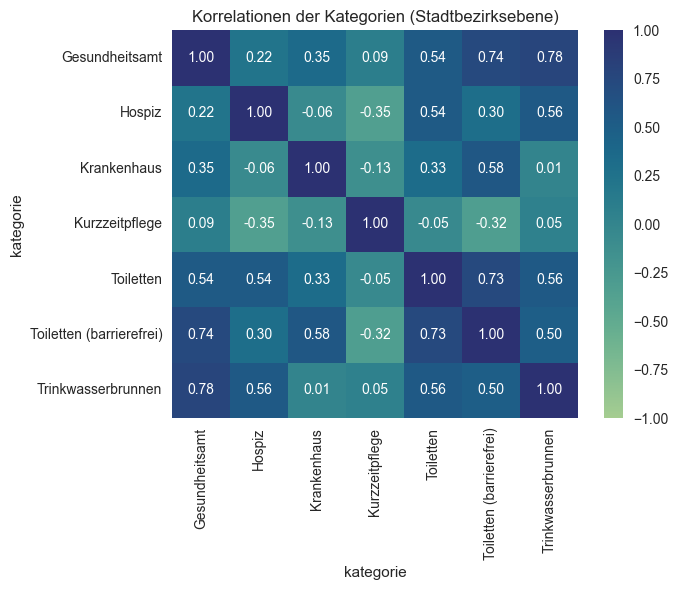

In [12]:
plt.figure(figsize=(7, 6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='crest', vmin=-1, vmax=1)
plt.title('Korrelationen der Kategorien (Stadtbezirksebene)')
plt.tight_layout()


## Barrierefreie Toiletten vs. alle Toiletten
Als Beispiel für Unterkategorien vergleichen wir das Verhältnis barrierefreier Toiletten zu allen Toiletten je Stadtbezirk.

Stadtbezirk
Brackel            0.200000
Hombruch           0.200000
Lütgendortmund     0.200000
Huckarde           0.200000
Innenstadt-West    0.192308
dtype: float64

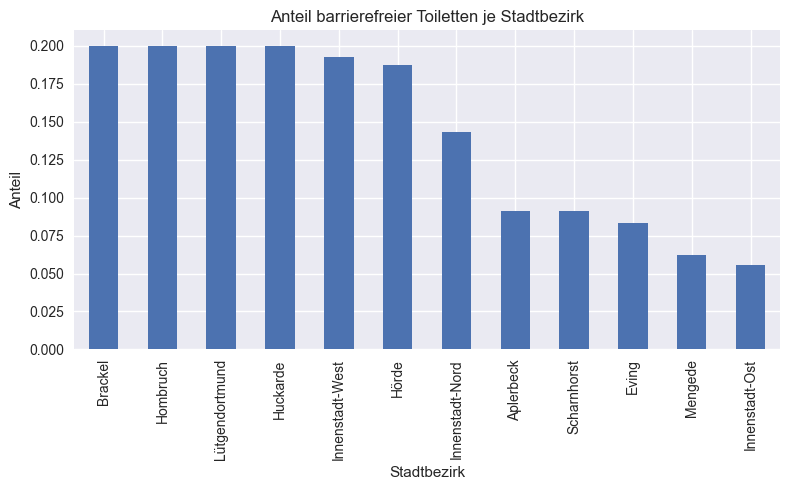

In [13]:
if 'Toiletten' in pivot.columns and 'Toiletten (barrierefrei)' in pivot.columns:
    ratio = pivot['Toiletten (barrierefrei)'] / pivot['Toiletten'].replace(0, np.nan)
    ratio = ratio.sort_values(ascending=False).dropna()

    plt.figure(figsize=(8, 5))
    ratio.plot(kind='bar')
    plt.title('Anteil barrierefreier Toiletten je Stadtbezirk')
    plt.ylabel('Anteil')
    plt.xlabel('Stadtbezirk')
    plt.tight_layout()

ratio.head()


## Rumliche Lage (Stichprobe)
Eine einfache Streuung der Koordinaten hilft, Cluster im Stadtgebiet sichtbar zu machen.

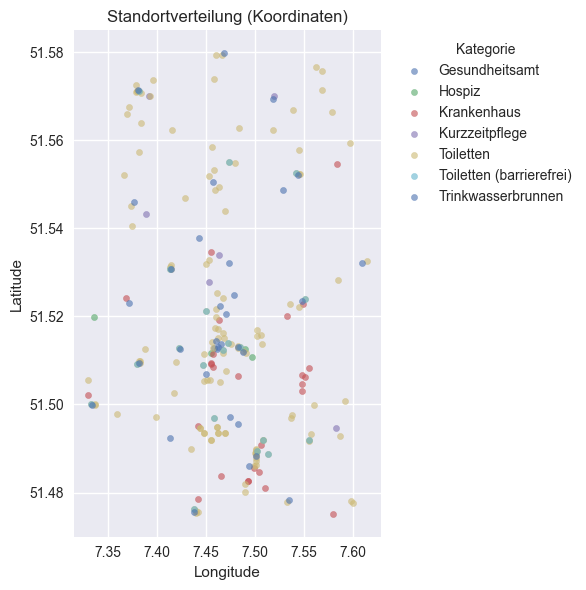

In [14]:
plt.figure(figsize=(6, 6))
for kategorie, subset in raw.groupby('kategorie'):
    plt.scatter(subset['lon'], subset['lat'], s=20, alpha=0.6, label=kategorie)

plt.title('Standortverteilung (Koordinaten)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Kategorie', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()


## Erste Insights (aus den Daten)
- Stadtbezirke mit vielen Standorten zeigen häufig eine hhere Dichte ?ber mehrere Kategorien hinweg.
- Toiletten und Trinkwasserbrunnen korrelieren positiv mit zentralen Bezirken (hohe Fußgängerfrequenz).
- Klinische Einrichtungen (Krankenhäuser, Hospize) sind deutlich seltener und clusterartig verteilt.
- Barrierefreie Toiletten sind in der Stichprobe ungleichmäßig verteilt; einige Bezirke haben einen deutlich höheren Anteil.

**Limitationen**:
- Es fehlen Bev?lkerungszahlen, Fl?che und Bedarfsindikatoren.
- Die Analyse betrachtet nur absolute Standortzahlen.
- Datens?tze sind klein und zeitlich nicht versioniert.
